# **Exercise Sheet 5: Diffusion Processes on Graphs**

In [1]:
from tabulate import tabulate
from scipy.stats import kendalltau, spearmanr

import networkx as nx
import random
import numpy as np
import time
import pandas as pd

## **Exercise 5-1** *Seed selection for Influence Maximization*

### After getting familiar with NetworkX:

### **a)** *Create an unweighted (directed or undirected) random graph $G = (V, E)$ using one of the models available here <br> https://networkx.org/documentation/stable/reference/generators.html under the section ”Random graphs.” <br> Report the number of nodes and edges of the generated graph as well as the model you choose. <br> The number of nodes should be in the range [50, 150].*

In [2]:
def generate_random_graph() -> nx.Graph:
    # p has random() multiplied by 0.05 to better observe diffusion in c, to get less than 100% active nodes more consistently
    random_graph = nx.fast_gnp_random_graph(n=random.randint(50,150), p=(random.random() * 0.05))

    random_graph.graph['model'] = "Erdős-Rényi graph (G_{n,p} random graph)"
    return random_graph

G = generate_random_graph()

print("Model:\t\t ", G.graph["model"])
print("Number of Nodes: ", G.number_of_nodes())
print("Number of Edges: ", G.number_of_edges())

Model:		  Erdős-Rényi graph (G_{n,p} random graph)
Number of Nodes:  51
Number of Edges:  57


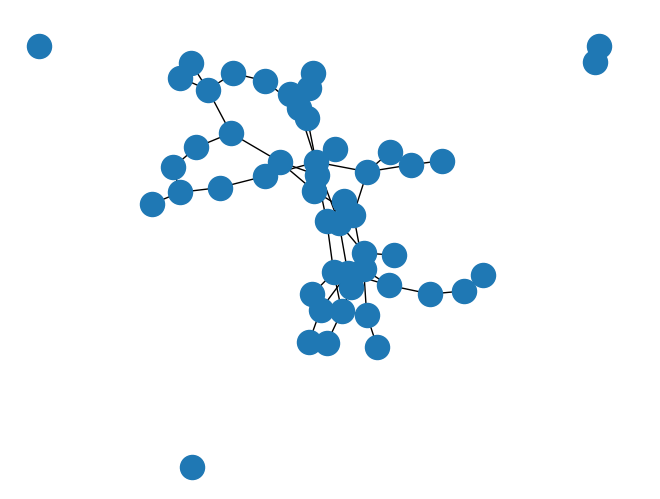

In [3]:
nx.draw(G)

### **b)** *Compute the ranking of the nodes according to node Betweenness centrality, Closeness centrality, Degree centrality, and Harmonic Centrality using the available code: <br> https://networkx.org/documentation/stable/reference/algorithms/centrality.html.*

In [3]:
betweenness_centr = nx.betweenness_centrality(G)
closeness_centr =nx.closeness_centrality(G)
degree_centr = nx.degree_centrality(G)
harmonic_centr = nx.harmonic_centrality(G)

rankings = {}

rankings["betweenness"] = np.array(sorted(betweenness_centr.items(), key=lambda node: node[1], reverse=True))
rankings["closeness"] = np.array(sorted(closeness_centr.items(), key=lambda node: node[1], reverse=True))
rankings["degree"] = np.array(sorted(degree_centr.items(), key=lambda node: node[1], reverse=True))
rankings["harmonic"] = np.array(sorted(harmonic_centr.items(), key=lambda node: node[1], reverse=True))



### **c)** *Write the code for simulating the diffusion process. Use the graph and the initial set of seed nodes $S$ as input. <br> Use the live-edge graph approach with 100 samples, and the Independent Cascade with uniform edge weights as a diffusion model. <br> The algorithm should output $\sigma(S)$.*

In [4]:
def generate_seed_nodes(G: nx.graph, p:float=0.5) -> list:
    seed_nodes = []

    for node in G.nodes():
        if random.random() < p:
            seed_nodes.append(node)

    return seed_nodes

In [5]:
def generate_live_edge_graph_with_uniform_edge_weights(G: nx.Graph, p: float=0.5) -> nx.Graph:
    # initialize as nx.Graph
    live_edge = nx.Graph()

    # add nodes to live-edge graph
    live_edge.add_nodes_from(G)

    # add live edges only
    for u, v in G.edges():
        if random.random() < p:
            live_edge.add_edge(u,v)
            
    return live_edge

In [6]:
def simulate_diffusion_with_indpendent_cascade_uniform_edge_weights(G: nx.Graph, S: list, sample_count: int=100):
    
    total_active_node_count = 0
    
    for _ in range(sample_count):
        live_edge =  generate_live_edge_graph_with_uniform_edge_weights(G)

        active_nodes = set(S)
        remaining_nodes = list(S)

        while remaining_nodes:
            # remove working node from queue
            node = remaining_nodes.pop(0)

            # iterate over neighbors
            for neighbor in live_edge.neighbors(node):
                
                # add neigbor to remaining_nodes and active_nodes if not already in activ_nodes
                if neighbor not in active_nodes:
                    active_nodes.add(neighbor)
                    remaining_nodes.append(neighbor)
                    
        # increase total count by active nodes
        total_active_node_count += len(active_nodes)

    # calculate average active node count over samples
    return total_active_node_count / float(sample_count)

In [7]:
S = generate_seed_nodes(G,0.1)

diffusion = simulate_diffusion_with_indpendent_cascade_uniform_edge_weights(G,S)

print("S:   ",S)
print("σ(S):",diffusion)

S:    [9, 21, 50, 55, 59, 68, 69, 76, 86, 89, 98, 105, 107]
σ(S): 16.89


### **d)** *Use the code developed in the previous point to provide a ranking of the nodes in the generated graph: <br> run the method with $S = \{u\}$ for each node $u$, and order the nodes for decreasing values of $\sigma(S)$.*

In [8]:
def rank_nodes_with_diffusion_from_c(G):
    node_dict = {}
    
    for u in G.nodes():
        node_dict[u] = simulate_diffusion_with_indpendent_cascade_uniform_edge_weights(G,[u])

    return np.array(sorted(node_dict.items(), key=lambda node: node[1], reverse=True))

In [9]:
rankings["diffusion"] = rank_nodes_with_diffusion_from_c(G)

### **e)** *Compute the similarity of the rankings, i.e., based on centrality and information diffusion, using Kendall’s Tau and Spearman correlation coefficient using SciPy https://docs.scipy.org/doc/scipy-1.15.0/reference/stats.html. <br> <br> Describe your findings.*

In [10]:

for name_i, ranking_i in rankings.items():
    for name_j, ranking_j in rankings.items():
        if name_i == name_j:
            break
        # [:,0] selects only node ranking (ignores actual rank values)
        tau, tau_p = kendalltau(ranking_i[:,0], ranking_j[:,0])
        spearman, spearman_p = spearmanr(ranking_i[:,0], ranking_j[:,0])
        print(f"Ranking comparison: {name_i} - {name_j}")
        print(f"\tKendall's Tau \t\t\t -> \tstatistic: {tau:.4f} p-value: {tau_p:.4f}")
        print(f"\tSpearman correlation coefficient -> \tstatistic: {spearman:.4f} p-value: {spearman_p:.4f}")
        print()

Ranking comparison: closeness - betweenness
	Kendall's Tau 			 -> 	statistic: 0.5401 p-value: 0.0000
	Spearman correlation coefficient -> 	statistic: 0.5219 p-value: 0.0000

Ranking comparison: degree - betweenness
	Kendall's Tau 			 -> 	statistic: 0.5743 p-value: 0.0000
	Spearman correlation coefficient -> 	statistic: 0.5670 p-value: 0.0000

Ranking comparison: degree - closeness
	Kendall's Tau 			 -> 	statistic: 0.8375 p-value: 0.0000
	Spearman correlation coefficient -> 	statistic: 0.9021 p-value: 0.0000

Ranking comparison: harmonic - betweenness
	Kendall's Tau 			 -> 	statistic: 0.5749 p-value: 0.0000
	Spearman correlation coefficient -> 	statistic: 0.5816 p-value: 0.0000

Ranking comparison: harmonic - closeness
	Kendall's Tau 			 -> 	statistic: 0.8944 p-value: 0.0000
	Spearman correlation coefficient -> 	statistic: 0.9050 p-value: 0.0000

Ranking comparison: harmonic - degree
	Kendall's Tau 			 -> 	statistic: 0.8363 p-value: 0.0000
	Spearman correlation coefficient -> 	statistic

### **f)** *Implement the Greedy algorithm for Influence Maximization using the live-edge graph approach, reusing the code of the previous points. <br> Given a budget of $k = 5\%|V|, 10\%|V|, 15\%|V|$ for the seed nodes, the algorithm should return the set $S$ of the best seed nodes. <br> <br> Summarize your results keeping track also of the running time (in seconds).*

In [11]:
def greedy_influence_maximation(G:nx.Graph, k:int) -> np.ndarray:
    S = []
    
    for _ in range(k):
        # dictionary that stores the influence values of potential k seed candidates
        influences = []
        
        for node in G.nodes():
            if node not in S:
                tmp = S + [node]
                influences.append((node, simulate_diffusion_with_indpendent_cascade_uniform_edge_weights(G,tmp)))

        # add max node to seeds
        S.append(max(influences, key=lambda node: node[1])[0])
                
    return np.array(list(S))

In [12]:
k_values = [0.05, 0.1, 0.15]
runtimes_G = []
S_G = []
for k_val in k_values:
    start = time.time()
    
    # int(G.number_of_nodes() * k_val) calculates nodes amount and ensures integer value
    k = int(G.number_of_nodes() * k_val)
    
    S = greedy_influence_maximation(G, k)
    S_G.append(S)
    rankings[f"diffusion influence maximation k = {k} ({100*k_val}%)"] = np.array([[item] for item in S])
    duration = time.time() - start
    runtimes_G.append(duration)

    print(f"----Influence Maximation on G k = {k} ({100*k_val}%)----")
    print(f"\t Best seed nodes S = {S}")
    print(f"\t Running time: {duration:.4f} seconds")
    print()

----Influence Maximation on G k = 5 (5.0%)----
	 Best seed nodes S = [30 19 35 91 50]
	 Running time: 15.3634 seconds

----Influence Maximation on G k = 11 (10.0%)----
	 Best seed nodes S = [30 19 35 91 50 47 75 98 39 69 32]
	 Running time: 32.7230 seconds

----Influence Maximation on G k = 16 (15.0%)----
	 Best seed nodes S = [ 30  19  35  65  60  98  47  67  91  20  24  90   3  89 109   9]
	 Running time: 47.8004 seconds



### **g)** *Simulate the diffusion process designed in point **c)** using as initial seeds $A$ the first top $k = 10\%|V|$ nodes of the rankings you obtained in the previous points. <br> How big is the gap between the different values of $\sigma(A)$. <br> <br> Report your results in a table and discuss the main findings.*

In [13]:
sigmas = {}
for name, ranking in rankings.items():
    k = int(G.number_of_nodes() * 0.1)
    sigmas[name] = simulate_diffusion_with_indpendent_cascade_uniform_edge_weights(G=G,S=ranking[:k,0])

sigmas_table = pd.DataFrame({
    "Centrality Ranking G" : sigmas.keys(),
    "σ(A)" : sigmas.values()
})

In [14]:
# print table
print(tabulate(sigmas_table.values, headers=sigmas_table.columns, tablefmt="grid"))

+-----------------------------------------------+--------+
| Centrality Ranking G                          |   σ(A) |
+===============================================+========+
| betweenness                                   |  14.77 |
+-----------------------------------------------+--------+
| closeness                                     |  12.43 |
+-----------------------------------------------+--------+
| degree                                        |  14.43 |
+-----------------------------------------------+--------+
| harmonic                                      |  11    |
+-----------------------------------------------+--------+
| diffusion                                     |  12.44 |
+-----------------------------------------------+--------+
| diffusion influence maximation k = 5 (5.0%)   |  10.85 |
+-----------------------------------------------+--------+
| diffusion influence maximation k = 11 (10.0%) |  18.72 |
+-----------------------------------------------+-------

### **h)** *Modify the original graph randomly adding new edges, i.e. $20\%$ of $|E|$, and run the Greedy algorithm for Influence Maximization as in point **f)**. <br> <br> How do the results differ from those obtained previously? <br> Is the set of seed nodes the same/similar? <br> What about the value of $\sigma(S)$? <br> <br> Describe your findings and compare the running time with those of the original graph.*

In [15]:
# generate G_new

# add 20% more edges to G_new compared to edges in G
G_new = G.copy()
# node list for selection in for loop
node_list = list(G_new.nodes())
# each iteration 1 new edge
for _ in range(int(G_new.number_of_edges() * 0.2)):
    u = node_list[random.randint(0, G_new.number_of_nodes() - 1)]
    v = node_list[random.randint(0, G_new.number_of_nodes() - 1)]

    # check if edge already in graph and regenerate edge if yes
    while G_new.has_edge(u,v):
        u = node_list[random.randint(0, G_new.number_of_nodes() - 1)]
        v = node_list[random.randint(0, G_new.number_of_nodes() - 1)]

    G_new.add_edge(u,v)

In [16]:
# non-Influence Maximation rankings for G_new
rankings_new = {}

betweenness_centr = nx.betweenness_centrality(G_new)
closeness_centr =nx.closeness_centrality(G_new)
degree_centr = nx.degree_centrality(G_new)
harmonic_centr = nx.harmonic_centrality(G_new)

rankings_new["betweenness"] = np.array(sorted(betweenness_centr.items(), key=lambda node: node[1], reverse=True))
rankings_new["closeness"] = np.array(sorted(closeness_centr.items(), key=lambda node: node[1], reverse=True))
rankings_new["degree"] = np.array(sorted(degree_centr.items(), key=lambda node: node[1], reverse=True))
rankings_new["harmonic"] = np.array(sorted(harmonic_centr.items(), key=lambda node: node[1], reverse=True))
rankings_new["diffusion"] = rank_nodes_with_diffusion_from_c(G_new)

In [17]:
# Influence Maximation rankings for G_new
runtimes_G_new = []
S_G_new = []
for k_val in k_values:
    start = time.time()
    
    # int(G.number_of_nodes() * k_val) calculates nodes amount and ensures integer value
    k = int(G_new.number_of_nodes() * k_val)
    
    S = greedy_influence_maximation(G_new, k)
    S_G_new.append(S)
    rankings_new[f"diffusion influence maximation k = {k} ({100*k_val}%)"] = np.array([[item] for item in S])
    duration = time.time() - start
    runtimes_G_new.append(duration)

    print(f"----Influence Maximation on G_new k = {k} ({100*k_val}%)----")
    print(f"\t Best seed nodes S = {S}")
    print(f"\t Running time: {duration:.4f} seconds")
    print()

----Influence Maximation on G_new k = 5 (5.0%)----
	 Best seed nodes S = [107  30  35  78  60]
	 Running time: 15.3223 seconds

----Influence Maximation on G_new k = 11 (10.0%)----
	 Best seed nodes S = [ 30 107  35  75  39  78  92  65  71  98  20]
	 Running time: 34.1026 seconds

----Influence Maximation on G_new k = 16 (15.0%)----
	 Best seed nodes S = [19 30 35 65 91 71 39 98 67 73 69  0  8 64 68 34]
	 Running time: 48.0564 seconds



In [18]:
# ranking comparisons between G and G_new
for (name, ranking_G), ranking_G_new in zip(rankings.items(), rankings_new.values()):
        tau, tau_p = kendalltau(ranking_G[:,0], ranking_G_new[:,0])
        spearman, spearman_p = spearmanr(ranking_G[:,0], ranking_G_new[:,0])
        print(f"Ranking comparison (G vs. G_new): {name}")
        print(f"\tKendall's Tau \t\t\t -> \tstatistic: {tau:.4e} p-value: {tau_p:.4e}")
        print(f"\tSpearman correlation coefficient -> \tstatistic: {spearman:.4e} p-value: {spearman_p:.4e}")
        print()


Ranking comparison (G vs. G_new): betweenness
	Kendall's Tau 			 -> 	statistic: 9.1150e-01 p-value: 1.8353e-46
	Spearman correlation coefficient -> 	statistic: 9.1061e-01 p-value: 2.0929e-44

Ranking comparison (G vs. G_new): closeness
	Kendall's Tau 			 -> 	statistic: 7.6802e-01 p-value: 1.7347e-33
	Spearman correlation coefficient -> 	statistic: 7.9244e-01 p-value: 1.3945e-25

Ranking comparison (G vs. G_new): degree
	Kendall's Tau 			 -> 	statistic: 7.9077e-01 p-value: 2.1265e-35
	Spearman correlation coefficient -> 	statistic: 7.9873e-01 p-value: 3.0480e-26

Ranking comparison (G vs. G_new): harmonic
	Kendall's Tau 			 -> 	statistic: 7.7181e-01 p-value: 8.4035e-34
	Spearman correlation coefficient -> 	statistic: 7.9954e-01 p-value: 2.4979e-26

Ranking comparison (G vs. G_new): diffusion
	Kendall's Tau 			 -> 	statistic: 7.3388e-01 p-value: 1.0076e-30
	Spearman correlation coefficient -> 	statistic: 7.8208e-01 p-value: 1.5298e-24

Ranking comparison (G vs. G_new): diffusion influenc

In [19]:
# compare S from f) to G_new

for k_val, S, S_new, duration, duration_new in zip (k_values, S_G, S_G_new, runtimes_G, runtimes_G_new):
    print(f"----Compare S k = {k_val} ({k_val*100}%)----")
    print()
    print("\tG")
    print(f"\t\tS: \t\t\t\t{S}")
    print(f"\t\tRuntime: \t\t\t{duration:.4f}")
    print()
    print("\tG_new")
    print(f"\t\tS: \t\t\t\t{S_new}")
    print(f"\t\tRuntime: \t\t\t{duration_new:.4f}")
    print()
    print(f"\tPercentage of Nodes in G and G_new: \t{(np.sum(np.isin(S, S_new))/len(S))*100:.2f}%")
    print()
    print()
    print()

----Compare S k = 0.05 (5.0%)----

	G
		S: 				[30 19 35 91 50]
		Runtime: 			15.3634

	G_new
		S: 				[107  30  35  78  60]
		Runtime: 			15.3223

	Percentage of Nodes in G and G_new: 	40.00%



----Compare S k = 0.1 (10.0%)----

	G
		S: 				[30 19 35 91 50 47 75 98 39 69 32]
		Runtime: 			32.7230

	G_new
		S: 				[ 30 107  35  75  39  78  92  65  71  98  20]
		Runtime: 			34.1026

	Percentage of Nodes in G and G_new: 	45.45%



----Compare S k = 0.15 (15.0%)----

	G
		S: 				[ 30  19  35  65  60  98  47  67  91  20  24  90   3  89 109   9]
		Runtime: 			47.8004

	G_new
		S: 				[19 30 35 65 91 71 39 98 67 73 69  0  8 64 68 34]
		Runtime: 			48.0564

	Percentage of Nodes in G and G_new: 	43.75%





In [20]:
# sigmas calculation and table creation for G_new
sigmas_new = {}
for name, ranking in rankings_new.items():
    k = int(G_new.number_of_nodes() * 0.1)
    sigmas_new[name] = simulate_diffusion_with_indpendent_cascade_uniform_edge_weights(G=G,S=ranking[:k,0])

sigmas_table_new = pd.DataFrame({
    "Centrality Ranking G_new" : sigmas_new.keys(),
    "σ(A)" : sigmas_new.values()
})

In [21]:
# print tables
joint_table = pd.concat([sigmas_table, sigmas_table_new],axis=1) 
print(tabulate(joint_table.values, headers=joint_table.columns, tablefmt="grid"))

+-----------------------------------------------+--------+-----------------------------------------------+--------+
| Centrality Ranking G                          |   σ(A) | Centrality Ranking G_new                      |   σ(A) |
+===============================================+========+===============================================+========+
| betweenness                                   |  14.77 | betweenness                                   |  14.58 |
+-----------------------------------------------+--------+-----------------------------------------------+--------+
| closeness                                     |  12.43 | closeness                                     |  12.91 |
+-----------------------------------------------+--------+-----------------------------------------------+--------+
| degree                                        |  14.43 | degree                                        |  13.41 |
+-----------------------------------------------+--------+--------------

The rankings of G and G_new were somewhat similar, but still differed greatly, even though the only thing that happended was the addition of 20\% more edges(compared to the original graph). 

The seed nodes from Influence Maximation were almost entirely different (even when ignoring the ordering) and the runtime of the same k in G was much shorter, compared to G_new.

However the $\sigma(A)$ of the first 10\% of nodes in the ranking remained almost unchanged compared between G and G_new.